# Predicting players rating

In this project you are going to predict the overall rating of soccer player based on their attributes
such as 'crossing', 'finishing etc.
The dataset you are going to use is from European Soccer Database
(https://www.kaggle.com/hugomathien/soccer) has more than 25,000 matches and more than
10,000 players for European professional soccer seasons from 2008 to 2016.
Download the data in the same folder and run the following commmand to get it in the environment

## Import Libraries

In [52]:

import sqlite3
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt 
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt


from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, RandomizedSearchCV
from sklearn.pipeline import make_pipeline

import pickle

In [3]:
#database.sqlite

#Player_Attributes



cnx = sqlite3.connect('database.sqlite')
cnx
df = pd.read_sql_query("SELECT * FROM Player_Attributes", cnx)
table_names = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", cnx)
print(table_names)
df.shape

                name
0    sqlite_sequence
1  Player_Attributes
2             Player
3              Match
4             League
5            Country
6               Team
7    Team_Attributes


(183978, 42)

In [4]:
print(df.columns)
print('*'*80)
df.head()

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')
********************************************************************************


,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [5]:
target = df.pop('overall_rating')

In [6]:
df.shape

(183978, 41)

In [7]:
target.head()

0    67.0
1    67.0
2    62.0
3    61.0
4    61.0
Name: overall_rating, dtype: float64

In [8]:

target.isnull().values.sum()

836

In [9]:
target.describe()

count    183142.000000
mean         68.600015
std           7.041139
min          33.000000
25%          64.000000
50%          69.000000
75%          73.000000
max          94.000000
Name: overall_rating, dtype: float64

<IPython.core.display.Javascript object>


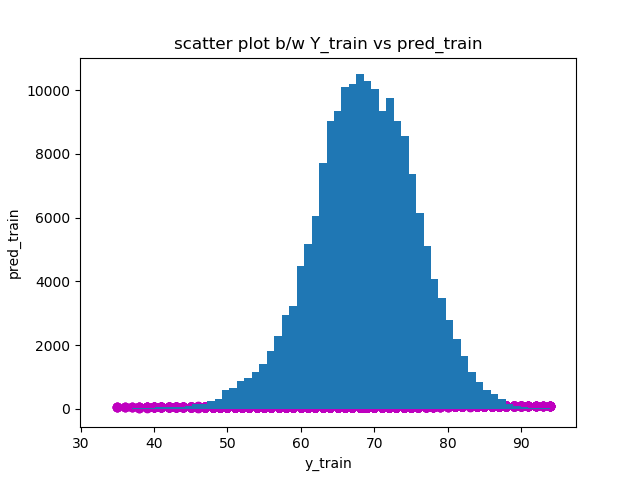

C:\Users\disiz\Anaconda3\lib\site-packages\numpy\lib\function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\disiz\Anaconda3\lib\site-packages\numpy\lib\function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([2.0000e+00, 5.0000e+00, 3.0000e+00, 3.0000e+00, 8.0000e+00,
        1.2000e+01, 2.4000e+01, 4.1000e+01, 4.7000e+01, 4.7000e+01,
        5.0000e+01, 9.2000e+01, 1.4200e+02, 1.5200e+02, 2.3100e+02,
        2.9500e+02, 5.8600e+02, 6.6500e+02, 8.6500e+02, 9.8000e+02,
        1.1600e+03, 1.4180e+03, 1.7980e+03, 2.2890e+03, 2.9500e+03,
        3.2390e+03, 4.4890e+03, 5.1610e+03, 6.0410e+03, 7.7040e+03,
        9.0300e+03, 9.3360e+03, 1.0112e+04, 1.0198e+04, 1.0492e+04,
        1.0281e+04, 1.0028e+04, 9.3540e+03, 9.7400e+03, 9.0440e+03,
        8.5560e+03, 7.3590e+03, 6.1500e+03, 5.1040e+03, 4.0640e+03,
        3.4610e+03, 2.7730e+03, 2.1740e+03, 1.6630e+03, 1.1660e+03,
        8.5500e+02, 6.0400e+02, 4.5600e+02, 2.9200e+02, 1.5100e+02,
        7.7000e+01, 6.8000e+01, 1.6000e+01, 1.6000e+01, 2.3000e+01]),
 array([33.        , 34.01666667, 35.03333333, 36.05      , 37.06666667,
        38.08333333, 39.1       , 40.11666667, 41.13333333, 42.15      ,
        43.16666667, 44.18333333, 45

In [10]:

plt.hist(target, 60, range=(33, 94))

In [11]:

# almost normal distribution so we can impute mean value for missing value in target
y = target.fillna(target.mean())

In [12]:

y.isnull().values.any()

False

In [13]:
features = df.columns[5:]

print(features)

Index(['preferred_foot', 'attacking_work_rate', 'defensive_work_rate',
       'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'free_kick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes'],
      dtype='object')


# Data Exploration :

In [17]:
df.columns

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'potential',
       'preferred_foot', 'attacking_work_rate', 'defensive_work_rate',
       'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'free_kick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes'],
      dtype='object')

In [18]:
for col in df.columns:
    unique_cat = len(df[col].unique())
    print("{col}--> {unique_cat}..{typ}".format(col=col, unique_cat=unique_cat, typ=df[col].dtype))

id--> 183978..int64
player_fifa_api_id--> 11062..int64
player_api_id--> 11060..int64
date--> 197..object
potential--> 57..float64
preferred_foot--> 3..object
attacking_work_rate--> 9..object
defensive_work_rate--> 20..object
crossing--> 96..float64
finishing--> 98..float64
heading_accuracy--> 97..float64
short_passing--> 96..float64
volleys--> 94..float64
dribbling--> 98..float64
curve--> 93..float64
free_kick_accuracy--> 98..float64
long_passing--> 96..float64
ball_control--> 94..float64
acceleration--> 87..float64
sprint_speed--> 86..float64
agility--> 82..float64
reactions--> 79..float64
balance--> 82..float64
shot_power--> 97..float64
jumping--> 80..float64
stamina--> 85..float64
strength--> 83..float64
long_shots--> 97..float64
aggression--> 92..float64
interceptions--> 97..float64
positioning--> 96..float64
vision--> 98..float64
penalties--> 95..float64
marking--> 96..float64
standing_tackle--> 96..float64
sliding_tackle--> 95..float64
gk_diving--> 94..float64
gk_handling--> 91..

we can see only four features have the type 'object'. here the feature named 'date' has no significance in this problem so can ignore it and perform one hot encoding on the rest of 3 features.

In [19]:
dummy_df = pd.get_dummies(df, columns=['preferred_foot', 'attacking_work_rate', 'defensive_work_rate'])
dummy_df.head()

,id,player_fifa_api_id,player_api_id,date,potential,crossing,finishing,heading_accuracy,short_passing,volleys,...,defensive_work_rate_9,defensive_work_rate__0,defensive_work_rate_ean,defensive_work_rate_es,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,defensive_work_rate_o,defensive_work_rate_ormal,defensive_work_rate_tocky
0,1,218353,505942,2016-02-18 00:00:00,71.0,49.0,44.0,71.0,61.0,44.0,...,0,0,0,0,0,0,1,0,0,0
1,2,218353,505942,2015-11-19 00:00:00,71.0,49.0,44.0,71.0,61.0,44.0,...,0,0,0,0,0,0,1,0,0,0
2,3,218353,505942,2015-09-21 00:00:00,66.0,49.0,44.0,71.0,61.0,44.0,...,0,0,0,0,0,0,1,0,0,0
3,4,218353,505942,2015-03-20 00:00:00,65.0,48.0,43.0,70.0,60.0,43.0,...,0,0,0,0,0,0,1,0,0,0
4,5,218353,505942,2007-02-22 00:00:00,65.0,48.0,43.0,70.0,60.0,43.0,...,0,0,0,0,0,0,1,0,0,0


In [39]:
X = dummy_df.drop(['id', 'date'], axis=1)

# imputing and splitting train , test

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
#imputing null value of each column with the mean of that column
imput = Imputer()
X_train = imput.fit_transform(X_train)
X_test = imput.fit_transform(X_test)


# Fitting the model

In [44]:
lm=LinearRegression()
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [46]:
print("Estimated Intercept Coefficient:",lm.intercept_)

Estimated Intercept Coefficient: -0.2217914270682968


In [48]:
print("len of coefficients array:",len(lm.coef_))
print("\nEstimated Coefficients",lm.coef_)

len of coefficients array: 65

Estimated Coefficients [-8.37644632e-06 -6.41423922e-06  4.46051807e-01  6.34901709e-03
  1.42964355e-02  5.69060683e-02  5.68530584e-02 -6.45554649e-03
  1.01254110e-02  1.14861674e-02  8.59178414e-03  9.73376387e-03
  1.12543620e-01  1.02239692e-02  1.71713179e-02 -1.17156293e-02
  1.73858633e-01  4.64843885e-03  1.18071444e-02  1.13529066e-02
 -1.34177534e-03  4.96811032e-02 -1.02313243e-02  1.06775610e-02
  3.47912169e-03 -4.85121139e-03 -1.80257483e-02  7.53136734e-03
  2.60603706e-02  9.08748698e-03 -2.00630921e-02  1.61976064e-01
  2.42316489e-02 -4.38798522e-02  4.69686364e-02  1.71621433e-02
  3.21163918e-01  3.20399772e-01  2.39817594e-01  6.44905012e-01
 -6.20555793e-01  1.50160161e+00  5.01354452e-01 -1.03093129e-01
 -8.16635829e-01 -2.03856219e-01  3.92822755e-01  1.07005485e+00
  1.50212647e-01  5.53271466e-01 -6.69846188e-01 -1.70584590e-01
  6.02020688e-03  6.67094287e-01  4.80804102e-01  4.82059358e-01
 -5.01974009e-01 -6.20555793e-01 -2.

# Model evaluation

In [47]:

print("""Linear Regressor accuracy is {lin}""".format(lin=lm.score(X_test, y_test)))

Linear Regressor accuracy is 0.8582791614795209


In [49]:
# Predicting training set output

pred_train=lm.predict(X_train)

# Predicting validation set output

pred_test=lm.predict(X_test)

# mean square error for the training dataset

mse_train=np.mean((y_train-pred_train)**2)

# mean square error for the validation dataset

mse_test=np.mean((y_test-pred_test)**2)


In [50]:
print('\nFitting a model X_train, and calculate MSE with y_train:',mse_train)
print('\nFitting a model X_train, and calculate MSE with X_test, y_test:',mse_test)


Fitting a model X_train, and calculate MSE with y_train: 6.854861160364281

Fitting a model X_train, and calculate MSE with X_test, y_test: 7.049125721272426


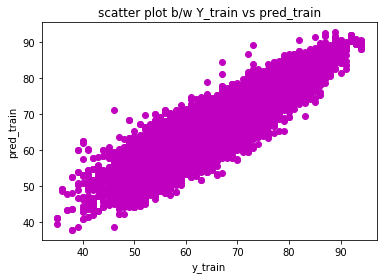

In [53]:
plt.scatter(y_train,pred_train,c='m')
plt.xlabel("y_train")
plt.ylabel("pred_train")
plt.title("scatter plot b/w Y_train vs pred_train")
plt.show()

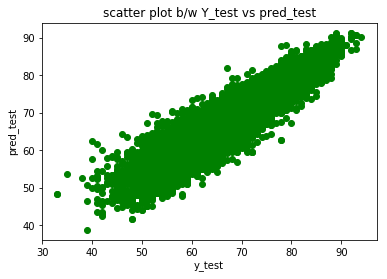

In [55]:
plt.scatter(y_test,pred_test,c='g')
plt.xlabel("y_test")
plt.ylabel("pred_test")
plt.title("scatter plot b/w Y_test vs pred_test")
plt.show()

In [62]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(y_test, pred_test))
print("Root mean square error:",rmse)

Root mean square error: 2.655018968156799


In [61]:
print("End of project 2")

End of project 2
